In [19]:
import numpy as np
import pandas as pd
import sys; sys.path.append('..')

from helpers.lift import area_ratio_scorer, area_ratio, plot_lift_chart

df = pd.read_csv('../data/engineered.csv')
df.head()

,Unnamed: 0,X1,X3,X5,X6,X7,X8,X9,X10,X11,...,payment_total,payment_avg,payment_std,payment_max,payment_min,payment_growth,payment_trend,payment_zero_count,payment_all_zero,payment_low_count
0,0,20000,2,24,2,2,-1,-1,-2,-2,...,689,114.833336,281.28308,689,0,0,59.057144,5,0,6
1,1,120000,2,26,-1,2,0,0,0,2,...,5000,833.333300,752.77264,2000,0,-2000,-200.000000,2,0,2
2,2,90000,2,34,0,0,0,0,0,0,...,11018,1836.333400,1569.81540,5000,1000,-3482,-454.571440,0,0,0
3,3,50000,2,37,0,0,0,0,0,0,...,8388,1398.000000,478.05817,2019,1000,1000,227.142850,0,0,0
4,4,50000,2,57,-1,0,-1,0,0,0,...,59049,9841.500000,13786.23000,36681,679,1321,3302.314200,0,0,2


In [20]:
from sklearn.model_selection import train_test_split

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## OPTIMIZATION

In [21]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define pipeline
dt_optimization_pipeline = Pipeline([
    ('dt_opt_clf', DecisionTreeClassifier())
])

# Define parameter distributions
param_distributions = {
    'dt_opt_clf__criterion': ['gini', 'entropy', 'log_loss'],
    'dt_opt_clf__splitter': ['best', 'random'],
    'dt_opt_clf__max_depth': [5, 10, 15, 20, None],
    'dt_opt_clf__max_leaf_nodes': [10, 50, 75, 100, None],
    'dt_opt_clf__min_samples_split': randint(2, 11),
    'dt_opt_clf__min_samples_leaf': randint(1, 11),
    'dt_opt_clf__min_weight_fraction_leaf': [0.0, 0.01, 0.05],
    'dt_opt_clf__max_features': [None, 'sqrt', 'log2'],
    'dt_opt_clf__min_impurity_decrease': [0.0, 0.01],
    'dt_opt_clf__ccp_alpha': [0.0, 0.01],
    'dt_opt_clf__class_weight': [None, 'balanced'],
    'dt_opt_clf__random_state': [42],
}

# RandomizedSearchCV setup
random_search_dt = RandomizedSearchCV(
    estimator=dt_optimization_pipeline,
    param_distributions=param_distributions,
    n_iter=500,  # Increase for broader search
    scoring=area_ratio_scorer,
    cv=10,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit search
random_search_dt.fit(X_train, y_train)

# Output best results
print("Best Params:", random_search_dt.best_params_)
print("Best CV Area Ratio:", random_search_dt.best_score_)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
[CV] END dt_opt_clf__ccp_alpha=0.0, dt_opt_clf__class_weight=balanced, dt_opt_clf__criterion=gini, dt_opt_clf__max_depth=15, dt_opt_clf__max_features=None, dt_opt_clf__max_leaf_nodes=None, dt_opt_clf__min_impurity_decrease=0.0, dt_opt_clf__min_samples_leaf=10, dt_opt_clf__min_samples_split=4, dt_opt_clf__min_weight_fraction_leaf=0.05, dt_opt_clf__random_state=42, dt_opt_clf__splitter=best; total time=   0.7s
[CV] END dt_opt_clf__ccp_alpha=0.0, dt_opt_clf__class_weight=balanced, dt_opt_clf__criterion=gini, dt_opt_clf__max_depth=20, dt_opt_clf__max_features=log2, dt_opt_clf__max_leaf_nodes=None, dt_opt_clf__min_impurity_decrease=0.01, dt_opt_clf__min_samples_leaf=8, dt_opt_clf__min_samples_split=7, dt_opt_clf__min_weight_fraction_leaf=0.01, dt_opt_clf__random_state=42, dt_opt_clf__splitter=random; total time=   0.0s
[CV] END dt_opt_clf__ccp_alpha=0.0, dt_opt_clf__class_weight=balanced, dt_opt_clf__criterion=gini, dt_opt_clf

In [22]:
import pandas as pd

optimization_results_df = pd.DataFrame(random_search_dt.cv_results_)
optimization_results_df.sort_values(ascending=False, by='mean_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt_opt_clf__ccp_alpha,param_dt_opt_clf__class_weight,param_dt_opt_clf__criterion,param_dt_opt_clf__max_depth,param_dt_opt_clf__max_features,param_dt_opt_clf__max_leaf_nodes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
108,0.706366,0.017084,0.002245,0.000809,0.0,balanced,log_loss,10,None,100,...,0.547852,0.512290,0.556083,0.561087,0.547957,0.549844,0.564758,0.547272,0.017302,1
10,1.780492,0.168674,0.002787,0.001570,0.0,balanced,log_loss,10,None,100,...,0.547852,0.512290,0.556083,0.561087,0.547957,0.549844,0.564758,0.547272,0.017302,1
370,0.623969,0.029269,0.002053,0.000333,0.0,balanced,gini,10,None,None,...,0.550029,0.508599,0.562222,0.558127,0.544438,0.552823,0.584599,0.546784,0.021649,3
438,0.050060,0.006651,0.002406,0.000887,0.0,None,entropy,20,None,None,...,0.547559,0.527473,0.565556,0.555578,0.539811,0.561058,0.571566,0.546723,0.016104,4
131,0.050421,0.008577,0.001793,0.000172,0.0,None,log_loss,15,None,75,...,0.562085,0.509804,0.561373,0.562250,0.533504,0.559344,0.556905,0.543910,0.018742,5


Best Params: {'dt_opt_clf__ccp_alpha': 0.0, 'dt_opt_clf__class_weight': 'balanced', 'dt_opt_clf__criterion': 'log_loss', 'dt_opt_clf__max_depth': 10, 'dt_opt_clf__max_features': None, 'dt_opt_clf__max_leaf_nodes': 100, 'dt_opt_clf__min_impurity_decrease': 0.0, 'dt_opt_clf__min_samples_leaf': 9, 'dt_opt_clf__min_samples_split': 9, 'dt_opt_clf__min_weight_fraction_leaf': 0.01, 'dt_opt_clf__random_state': 42, 'dt_opt_clf__splitter': 'best'}
Best CV Area Ratio: 0.5472718764024769

In [31]:
from sklearn.tree import DecisionTreeClassifier

optimized_model = DecisionTreeClassifier(
                                ccp_alpha=0.0,
                                class_weight='balanced', 
                                criterion='log_loss', 
                                max_depth=10, 
                                max_features=None, 
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_samples_leaf=9, 
                                min_samples_split=9, 
                                min_weight_fraction_leaf=0.01, 
                                random_state=42, 
                                splitter='best'
                            )

optimized_model.fit(X_train, y_train)

,criterion,'log_loss'
,splitter,'best'
,max_depth,10
,min_samples_split,9
,min_samples_leaf,9
,min_weight_fraction_leaf,0.01
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [32]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_optimized = optimized_model.predict(X_train)
y_train_proba_optimized = optimized_model.predict_proba(X_train)[:, 1]

y_test_pred_optimized = optimized_model.predict(X_test)
y_test_proba_optimized = optimized_model.predict_proba(X_test)[:, 1]

train_optimized_error = 1 - accuracy_score(y_train, y_train_pred_optimized)
train_optimized_area = area_ratio(y_train, y_train_proba_optimized)

test_optimized_error = 1 - accuracy_score(y_test, y_test_pred_optimized)
test_optimized_area = area_ratio(y_test, y_test_proba_optimized)



In [33]:
print(f'TRAIN: Error Rate {train_optimized_error:.4f}\n')
print(f'TRAIN: Area Ratio {train_optimized_area:.4f}\n')
print("TRAIN: Classification Report")
print(classification_report(y_train, y_train_pred_optimized, digits=4, zero_division=0))

TRAIN: Error Rate 0.2448

TRAIN: Area Ratio 0.6011

TRAIN: Classification Report
              precision    recall  f1-score   support

           0     0.8934    0.7790    0.8323     16357
           1     0.4615    0.6709    0.5468      4618

    accuracy                         0.7552     20975
   macro avg     0.6775    0.7249    0.6896     20975
weighted avg     0.7983    0.7552    0.7694     20975



In [34]:
print(f'TEST: Error Rate {test_optimized_error:.4f}\n')
print(f'TEST: Area Ratio {test_optimized_area:.4f}\n')
print("TEST: Classification Report")
print(classification_report(y_test, y_test_pred_optimized, digits=4, zero_division=0))

TEST: Error Rate 0.2563

TEST: Area Ratio 0.5370

TEST: Classification Report
              precision    recall  f1-score   support

           0     0.8780    0.7779    0.8249      6978
           1     0.4480    0.6252    0.5220      2012

    accuracy                         0.7437      8990
   macro avg     0.6630    0.7016    0.6735      8990
weighted avg     0.7818    0.7437    0.7571      8990



In [35]:
sorted_idx = np.argsort(-y_test_proba_optimized)
y_true_sorted = y_test.iloc[sorted_idx].reset_index(drop=True)

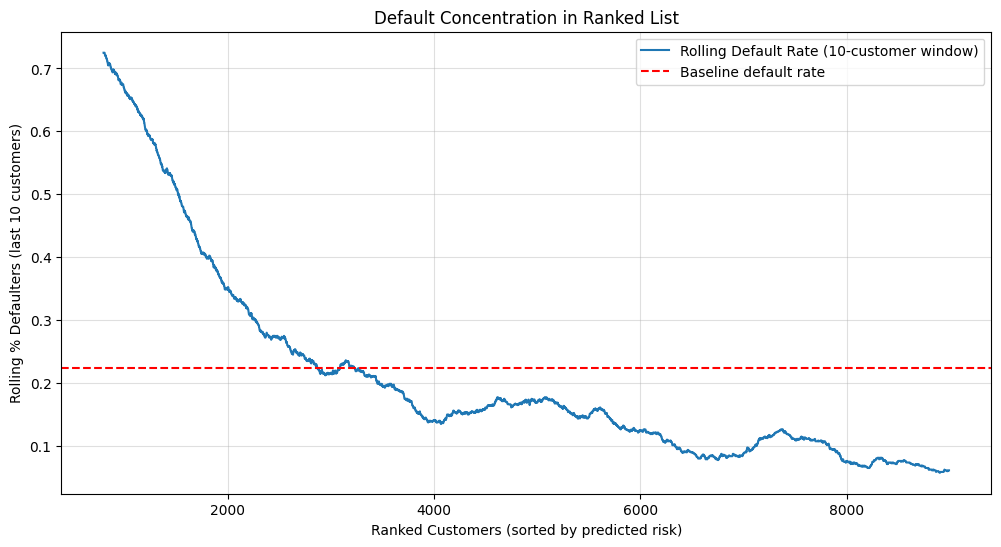

In [36]:
window_size = 800  # rolling over 10 customers
rolling_default_rate = y_true_sorted.rolling(window=window_size).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(
    rolling_default_rate.values,
    label="Rolling Default Rate (10-customer window)"
)

# Baseline average default rate in test set
plt.axhline(y=y_test.mean(), color="red", linestyle="--", label="Baseline default rate")

plt.xlabel("Ranked Customers (sorted by predicted risk)")
plt.ylabel("Rolling % Defaulters (last 10 customers)")
plt.title("Default Concentration in Ranked List")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [37]:
import pandas as pd
import numpy as np

# Total number of customers
n = len(y_true_sorted)

# Total defaults
total_defaults = y_true_sorted.sum()

decile_results = []

# For each decile (10%, 20%, ..., 100%)
for d in range(5, 110, 5):
    cutoff = int((d/100) * n)  # number of customers in top d%
    captured_defaults = y_true_sorted.iloc[:cutoff].sum()
    captured_pct = (captured_defaults / total_defaults) * 100
    decile_results.append({"Top % Population": f"Top {d}%", 
                           "Defaults Captured (%)": round(captured_pct, 2)})

# Create table
decile_df = pd.DataFrame(decile_results)
print(decile_df)


   Top % Population  Defaults Captured (%)
0            Top 5%                  16.90
1           Top 10%                  31.56
2           Top 15%                  42.79
3           Top 20%                  50.10
4           Top 25%                  57.11
5           Top 30%                  61.53
6           Top 35%                  67.10
7           Top 40%                  70.23
8           Top 45%                  73.11
9           Top 50%                  77.24
10          Top 55%                  81.06
11          Top 60%                  83.95
12          Top 65%                  87.18
13          Top 70%                  89.12
14          Top 75%                  90.85
15          Top 80%                  93.99
16          Top 85%                  95.87
17          Top 90%                  97.32
18          Top 95%                  99.11
19         Top 100%                 100.00
20         Top 105%                 100.00


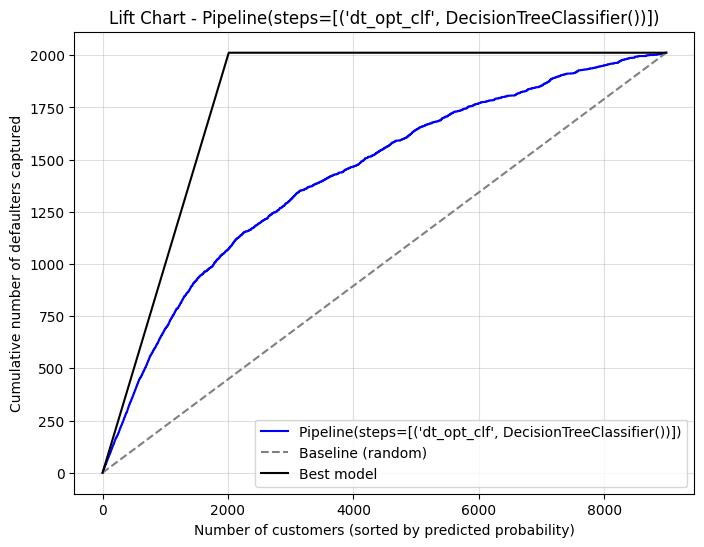

In [38]:
plot_lift_chart(y_test, y_test_proba_optimized, dt_optimization_pipeline)